# BTCV Dataset Visualization

Visualize the BTCV (Beyond the Cranial Vault) multi-organ segmentation dataset with option to save images.

In [6]:
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

DATA_ROOT = Path("/srv/local/shared/shared_data/bctv/btcv/Training")
OUTPUT_DIR = Path("/home/jtu9/SAM/medsam/inference/results/sample")
SAVE_IMAGES = True  # Set to False to disable saving

In [7]:
def load_btcv_sample(case_id, slice_idx):
    """Load image and mask for a BTCV case/slice."""
    img_path = DATA_ROOT / "image" / case_id / f"{slice_idx}.jpg"
    mask_path = DATA_ROOT / "mask" / case_id / f"{slice_idx}.npy"
    
    image = np.array(Image.open(img_path).convert('RGB'))
    mask = np.load(mask_path)
    return image, mask

def get_available_slices(case_id):
    """Get list of slice indices for a case."""
    case_dir = DATA_ROOT / "image" / case_id
    return sorted([int(f.stem) for f in case_dir.glob("*.jpg")])

In [8]:
def create_overlay(image, mask, alpha=0.4):
    """Create overlay of multi-label mask on image."""
    from matplotlib import cm
    
    # Resize mask to match image if needed
    img_h, img_w = image.shape[:2]
    if mask.shape != (img_h, img_w):
        mask_pil = Image.fromarray(mask.astype(np.float32), mode='F')
        mask = np.array(mask_pil.resize((img_w, img_h), Image.NEAREST))
    
    overlay = image.copy().astype(float)

    # Use colormap for multi-label mask
    mask_max = mask.max() if mask.max() > 0 else 1
    mask_normalized = mask / mask_max
    colors = cm.nipy_spectral(mask_normalized)[:, :, :3] * 255

    # Blend where mask > 0
    mask_bool = mask > 0
    for c in range(3):
        overlay[:, :, c] = np.where(
            mask_bool,
            overlay[:, :, c] * (1 - alpha) + colors[:, :, c] * alpha,
            overlay[:, :, c]
        )
    return overlay.astype(np.uint8)

def visualize_btcv(image, mask, case_id, slice_idx):
    """Display input, GT mask, and overlay."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title(f"Input: {case_id}/{slice_idx}")
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='nipy_spectral')
    axes[1].set_title(f"GT Mask (labels: {np.unique(mask[mask>0]).astype(int).tolist()})")
    axes[1].axis('off')

    overlay = create_overlay(image, mask)
    axes[2].imshow(overlay)
    axes[2].set_title("Input + GT Overlay")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

def save_btcv_images(image, mask, case_id, slice_idx, output_dir, save=True):
    """Save input, GT mask, and overlay as separate images."""
    if not save:
        return
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    prefix = f"{case_id}_slice{slice_idx}"
    Image.fromarray(image).save(output_dir / f"{prefix}_input.png")
    # Save mask as grayscale (scaled for visibility)
    mask_vis = ((mask / mask.max()) * 255).astype(np.uint8) if mask.max() > 0 else mask.astype(np.uint8)
    Image.fromarray(mask_vis).save(output_dir / f"{prefix}_gt.png")
    # Save overlay
    overlay = create_overlay(image, mask)
    Image.fromarray(overlay).save(output_dir / f"{prefix}_overlay.png")
    print(f"Saved: {output_dir}/{prefix}_*.png")

Case: img0001, Slice: 73
Image shape: (369, 369, 3), Mask shape: (512, 512)
Unique labels: [0, 6, 8, 9]


/srv/local/shared/temp/tmp1/jtu9/tmp/ipykernel_4157842/2494171718.py:8: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask.astype(np.float32), mode='F')


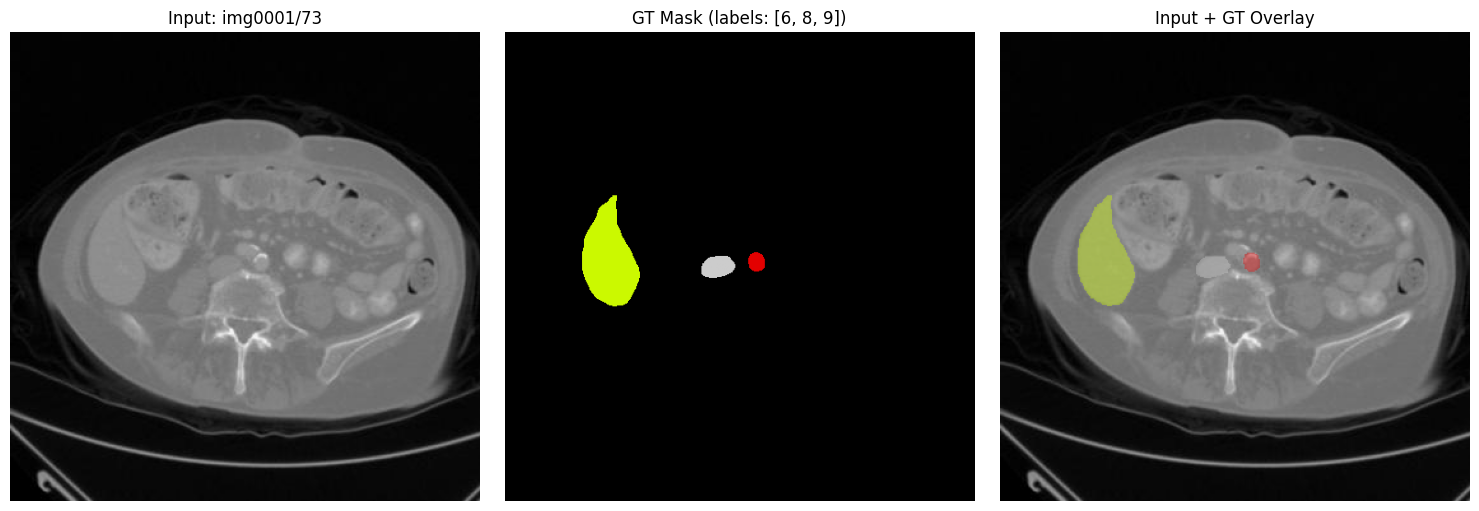

Saved: /home/jtu9/SAM/medsam/inference/results/sample/img0001_slice73_*.png


In [9]:
# Visualize a single sample
case_id = "img0001"
slices = get_available_slices(case_id)
slice_idx = slices[len(slices) // 2]  # Middle slice

image, mask = load_btcv_sample(case_id, slice_idx)
print(f"Case: {case_id}, Slice: {slice_idx}")
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
print(f"Unique labels: {np.unique(mask).astype(int).tolist()}")

visualize_btcv(image, mask, case_id, slice_idx)
save_btcv_images(image, mask, case_id, slice_idx, OUTPUT_DIR, save=SAVE_IMAGES)

Total cases: 24


/srv/local/shared/temp/tmp1/jtu9/tmp/ipykernel_4157842/2494171718.py:8: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask.astype(np.float32), mode='F')


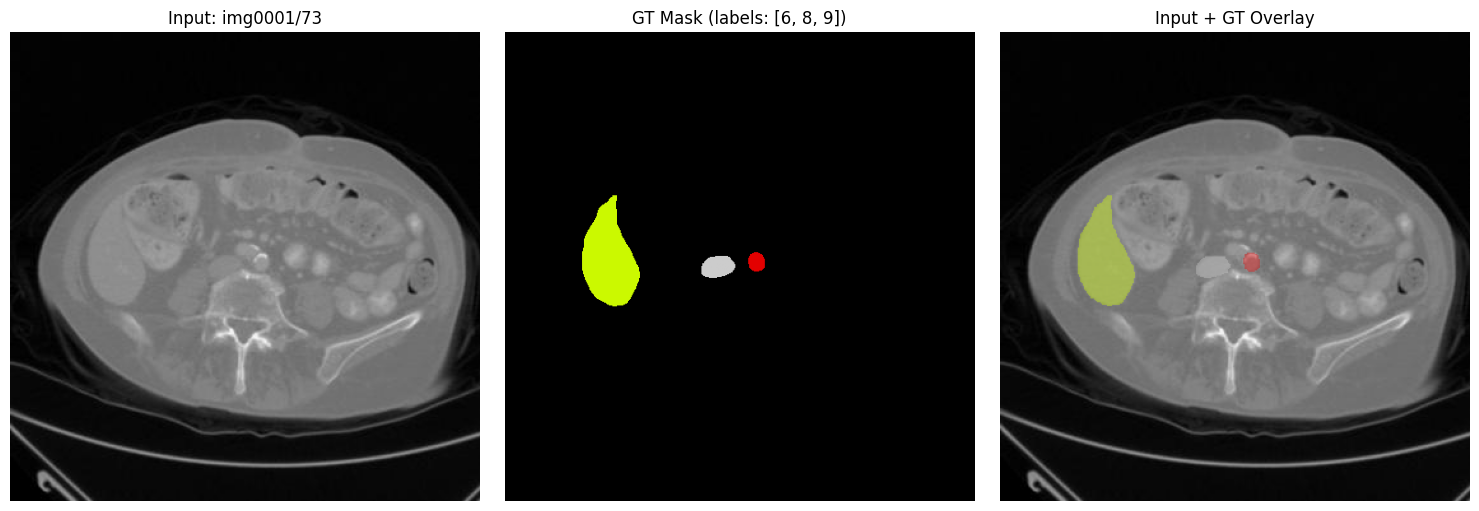

Saved: /home/jtu9/SAM/medsam/inference/results/sample/img0001_slice73_*.png


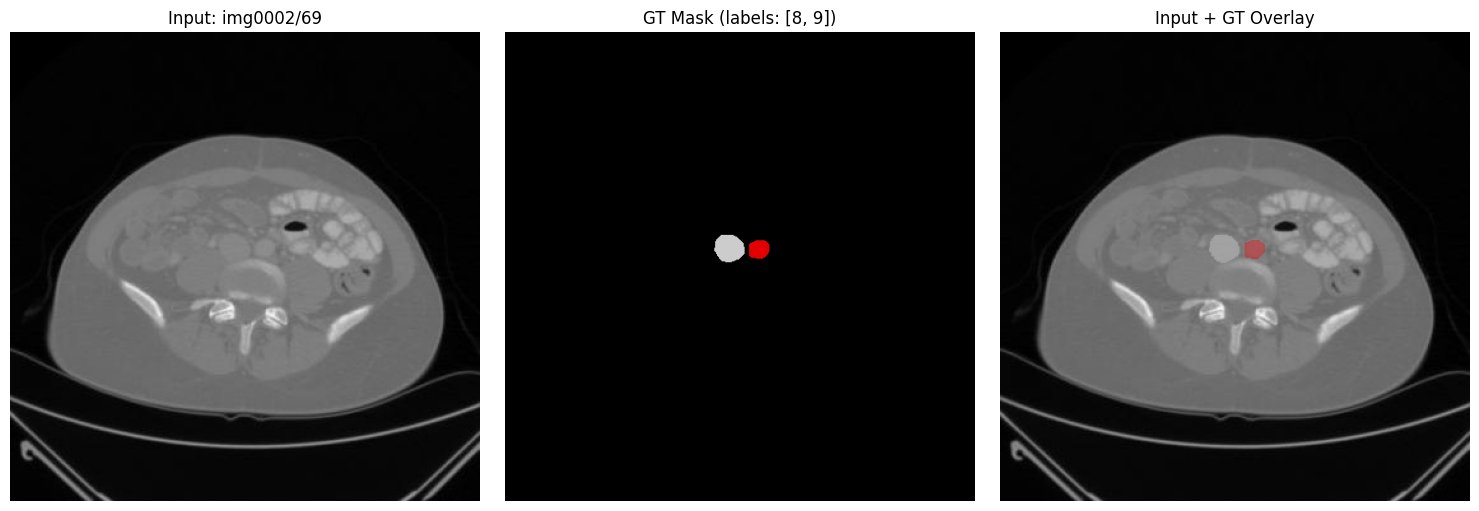

Saved: /home/jtu9/SAM/medsam/inference/results/sample/img0002_slice69_*.png


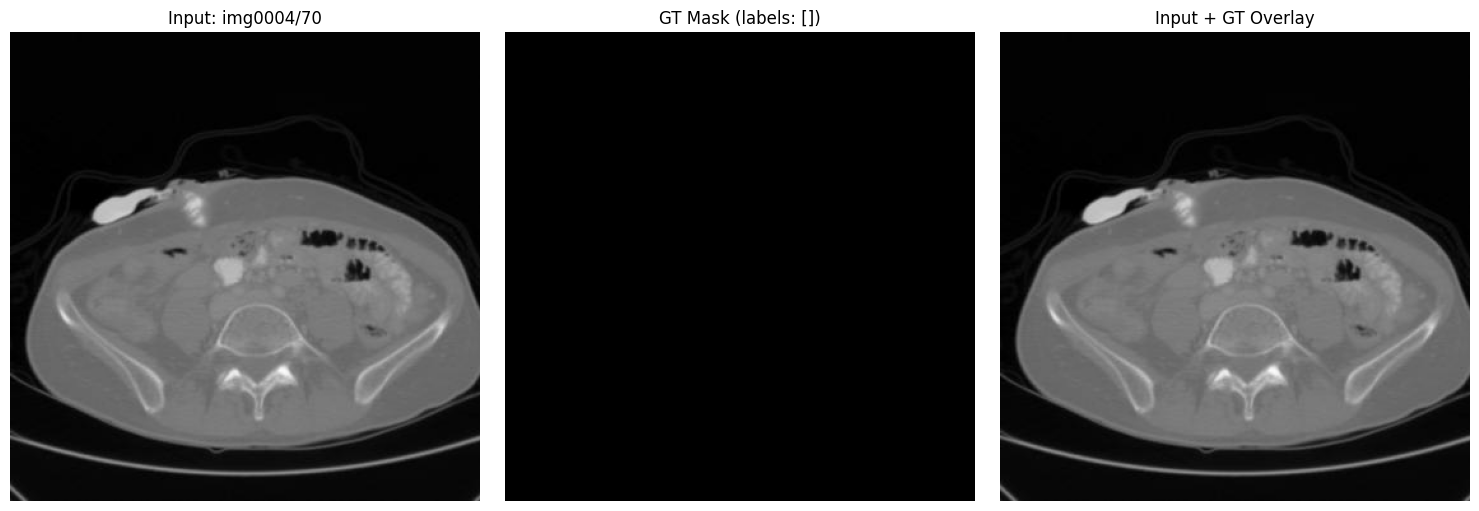

Saved: /home/jtu9/SAM/medsam/inference/results/sample/img0004_slice70_*.png


In [10]:
# Visualize one slice from multiple cases
cases = sorted([d.name for d in (DATA_ROOT / "image").iterdir() if d.is_dir()])
print(f"Total cases: {len(cases)}")

for case_id in cases[:3]:  # First 3 cases
    slices = get_available_slices(case_id)
    slice_idx = slices[len(slices) // 2]
    image, mask = load_btcv_sample(case_id, slice_idx)
    visualize_btcv(image, mask, case_id, slice_idx)
    save_btcv_images(image, mask, case_id, slice_idx, OUTPUT_DIR, save=SAVE_IMAGES)

In [11]:
# Save consecutive slices from one case
CONSECUTIVE_OUTPUT_DIR = Path("/home/jtu9/SAM/medsam/inference/results/consecutive")
CONSECUTIVE_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

case_id = "img0001"
slices = get_available_slices(case_id)

# Sample consecutive slices (e.g., 10 slices from middle)
n_slices = 10
start_idx = len(slices) // 2 - n_slices // 2
consecutive_slices = slices[start_idx:start_idx + n_slices]

print(f"Case: {case_id}, Saving {len(consecutive_slices)} consecutive slices: {consecutive_slices}")

for slice_idx in consecutive_slices:
    image, mask = load_btcv_sample(case_id, slice_idx)
    overlay = create_overlay(image, mask)

    # Save input and overlay
    prefix = f"{case_id}_slice{slice_idx:03d}"
    Image.fromarray(image).save(CONSECUTIVE_OUTPUT_DIR / f"{prefix}_input.png")
    Image.fromarray(overlay).save(CONSECUTIVE_OUTPUT_DIR / f"{prefix}_overlay.png")

print(f"Saved to: {CONSECUTIVE_OUTPUT_DIR}")

Case: img0001, Saving 10 consecutive slices: [68, 69, 70, 71, 72, 73, 74, 75, 76, 77]


/srv/local/shared/temp/tmp1/jtu9/tmp/ipykernel_4157842/2494171718.py:8: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask.astype(np.float32), mode='F')


Saved to: /home/jtu9/SAM/medsam/inference/results/consecutive
